In [2]:
!pip install pandas==1.5.3

import warnings
import sys, os, cv2, glob, json, gc, shutil
import multiprocessing
from multiprocessing import Pool

sys.path.append('./utils')

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoFileClip
import skvideo.io

import pandas as pd
import numpy as np
import circstat as CS
import scipy as sc
import math, random

import itertools
from itertools import chain
from tqdm import tqdm


from processing import *
from kinematics import *
from skeleton import *

warnings.filterwarnings("ignore")

os.makedirs('./data',exist_ok=True)
os.makedirs('./utils',exist_ok=True)

#download custom processing scripts if not already downloaded
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/kinematics.py
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/circstat.py
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/processing.py
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/skeleton.py

#download example data or upload your own json annotations

#--------------------------------------------------------------------------------------
# Download example raw data from figshare or specify path to your own json annotations |
#--------------------------------------------------------------------------------------

#!wget -P . https://figshare.com/ndownloader/articles/25316500/versions/1
# #unzip data into ./data folder and remove zip file
# !unzip ./1 -d ./data
# !rm ./1
#uncomment install if running on google colab
#%pip install scikit-video

DEIDENTIFY = True #set to True to deidentify data, and exclude xy coordinates and pixel values from output
OVERWRITE = True
USE_CENTER_INSTANCE = False
USE_BEST_INSTANCE = True

dataset = 'PANDA2'
json_path = f'./data/annotations'
json_files = os.listdir(json_path)
directory = f'./data'

save_path = f'./pose_estimates/{dataset}_pose_estimates'

os.makedirs(save_path, exist_ok=True)

kp_mapping = {0:'Nose', 1:'Neck', 2:'RShoulder', 3:'RElbow', 4:'RWrist', 5:'LShoulder', 6:'LElbow',
              7:'LWrist', 8:'RHip', 9:'RKnee', 10:'RAnkle', 11:'LHip',
              12:'LKnee', 13:'LAnkle', 14:'REye', 15:'LEye', 16:'REar', 17:'LEar'}

# Define the DataFrame columns as specified
columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c','fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']
data = []  # This will hold the data to be loaded into the DataFrame

vid_info = pd.read_csv(f'./data/{dataset}_video_info.csv')
# remove all video ending in _0 
vid_info = vid_info[~vid_info['video'].str.endswith('_0')].reset_index(drop=True)

# ID is the first number. keep only the last of each ID
vid_info['ID'] = vid_info['video'].str.split('_').str[0]
vid_info = vid_info.sort_values('video').drop_duplicates(subset=['ID'], keep='last').reset_index(drop=True)
vid_info = vid_info.drop(columns=['ID'])



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
# keep only id in video column
vid_info['video'] = vid_info['video'].str.split('_').str[0]

In [6]:
len(vid_info)

1048

In [7]:
# Smooth detections and compute features
pose_estimate_path = f'./pose_estimates/{dataset}_pose_estimates'
csv_path = f'{pose_estimate_path}/pose_estimates_{dataset}.csv'
save_path = f'{pose_estimate_path}/pose_estimates_{dataset}_processed.csv'

# List of subdirectories to create
subdirs = [
    "",
    "xdf",
    "adf",
    "xy_features",
    "angle_features",
    "xy_features/total",
    "angle_features/total",
    "xy_features/windows",
    "angle_features/windows",
    "smooth",
    "anim"
]

# Create necessary directories
for subdir in subdirs:
    os.makedirs(f'{pose_estimate_path}/{subdir}', exist_ok=True)

print(pose_estimate_path)


./pose_estimates/PANDA2_pose_estimates


In [13]:
# format files as pkl with openpose standard and bodypart labels

def process_file(args):
    """Function to process a single file."""
    file_number, file, json_path, save_path, vid_info, kp_mapping = args
    # Construct the full file path
    file_path = os.path.join(json_path, file)
    fname = file.split('.')[0]
    interim = []

    if not OVERWRITE and os.path.exists(f'{save_path}/{fname}.pkl'):
        return

    # Open and load the JSON data
    try: 
        with open(file_path, 'r') as f:
            frames = json.load(f)
            info = vid_info[vid_info['video'] == fname]
            fps = vid_info['fps'].values[0]

            pixel_x = vid_info['width'].values[0]
            pixel_y = vid_info['height'].values[0]
            
            center_x = pixel_x / 2
            center_y = pixel_y / 2
            
            # Iterate through each frame in the JSON file
            for frame in frames:
                frame_id = frame['frame_id']
                if 'instances' in frame and len(frame['instances']) > 0:

                    if USE_CENTER_INSTANCE:
                        instance_id = get_center_instance(frame['instances'], center_x, center_y)
                    elif USE_BEST_INSTANCE:
                        instance_id = get_best_instance(frame['instances'])
                    else:
                        instance_id = 0

                    keypoints = frame['instances'][instance_id]['keypoints']
                    confidence = frame['instances'][instance_id]['keypoint_scores']
                    keypoints, confidence = convert_coco_to_openpose(keypoints, confidence)

                    # Iterate through each keypoint
                    for part_idx, (x, y) in enumerate(keypoints):

                        bp = kp_mapping[part_idx]
                        fps = fps
                        time = frame_id / fps
                        c = confidence[part_idx]

                        row = [file_number, fname, bp, frame_id, x, y, c, fps, pixel_x, pixel_y, time, part_idx]
                        interim.append(row)

        interim_df = pd.DataFrame(interim, columns=columns)
        # ensure savepath exists
        os.makedirs(save_path, exist_ok=True)
        interim_df.to_csv(f'{save_path}/{fname}.csv', index=False)

        del interim_df
        return
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return
    
def process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping):
    """Run the annotation processing using multiprocessing."""
    args = [
        (file_number, file, json_path, save_path, vid_info, kp_mapping)
        for file_number, file in enumerate(json_files)
    ]

    # Set up a pool of workers
    with Pool(processes=20) as pool:
        pool.map(process_file, args)


In [14]:
process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping)

Error processing file ./data/annotations/.DS_Store: 'utf-8' codec can't decode byte 0xb9 in position 557: invalid start byte


In [15]:
# check that all files processed
processed_files = os.listdir(save_path)
print(f"Processed {len(processed_files)} files out of {len(json_files)} JSON files.")

Processed 1057 files out of 1058 JSON files.


In [17]:
save_path = "/workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/pose_estimates"

In [18]:
csv_path = f'{save_path}/pose_estimates_{dataset}.csv'
output_csv_path = f'{save_path}/pose_estimates_{dataset}_b.csv'
chunksize = 1000  # Number of rows per chunk

# Define the new headers
new_headers = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c', 'fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']

# Read the CSV file in chunks
chunk_iterator = pd.read_csv(csv_path, chunksize=chunksize)

# Process the first chunk
first_chunk = next(chunk_iterator)
first_chunk.columns = new_headers
first_chunk.to_csv(output_csv_path, mode='w', index=False)

# Process the rest of the chunks and append them to the new CSV file without headers
for chunk in chunk_iterator:
    chunk.columns = new_headers
    chunk.to_csv(output_csv_path, mode='a', index=False, header=False)

# rename the csv file
os.rename(csv_path, f'{save_path}/pose_estimates_{dataset}_x.csv')
os.rename(output_csv_path, csv_path)


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/pose_estimates/pose_estimates_PANDA2.csv'

In [20]:
pose_estimate_path = '/workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/pose_estimates'

In [41]:
def process_dataframe(file):
    df = pd.read_csv(os.path.join(pose_estimate_path, file))

    if df.empty:
        #print("DataFrame is empty, skipping processing.")
        return
    # print(f"Processing DataFrame for video_number: {df['video_number'].iloc[0]}")
    try:
        if dataset == 'Youtube':
            session = df['video'].unique()[0].split('_')[1][0]
            infant = df['video'].unique()[0].split('_')[1][3:]
            age = '3Month'
        elif dataset == 'Clinical':
            # split based on naming convention
            session = df['video'].unique()[0].split('_')[1][1]
            infant = df['video'].unique()[0].split('_')[0][-1]
            age = '3Month'
        elif dataset == 'gma_score_prediction': 
            session = 0
            infant = df['video'].unique()[0]
            age = '3Month'
        elif dataset == 'CHOP': 
            session = df['video'].unique()[0].split('_')[1]
            infant = df['video'].unique()[0].split('_')[0]
            age = df['video'].unique()[0].split('_')[2]
        elif dataset == 'PANDA2':
            session = 0
            infant = df['video'].unique()[0]
            age = '3Month'
        
        # print(f'infant: {infant} {session} {age}')


        median_window = 1
        mean_window = 1
        delta_window = 0.25  # Smoothing applied to delta_x, velocity, acceleration

        df['x'] = pd.to_numeric(df['x'])
        df['y'] = pd.to_numeric(df['y'])

        #filter low confidence detections
        #df = df[df['c'] > 0.5]

        # Interpolate
        df = df.groupby(['video', 'bp']).apply(interpolate_df).reset_index(drop=True)

        # Median and mean filter
        median_window = 0.5
        mean_window = 0.5
        df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'y', median_window, mean_window)).reset_index(drop=True)
        df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'x', median_window, mean_window)).reset_index(drop=True)
        
        df = normalise_skeletons(df) 
        df.to_csv(f'/workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/smooth/{infant}_{session}_{age}_smooth_norm.csv')
    
    except:
        f'could not process video {df["video"].unique()[0]}'
        return
    
    try:
        # Rotate and normalise by reference
        xdf = get_dynamics_xy(df, delta_window)   
        print(f'saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/{infant}_{session}_{age}_smooth_norm_xy.csv') 
        xdf.to_csv(f'/workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/{infant}_{session}_{age}_smooth_norm_xy.csv')

        adf = get_joint_angles(df)
        adf = get_dynamics_angle(adf, delta_window)
        adf.to_csv(f'/workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/adf/{infant}_{session}_{age}_smooth_norm_ang.csv')

    except KeyError as e:
        print(f'KeyError for video {df["video"].unique()[0]}: {e}')
        return


In [42]:
pose_estimate_files = os.listdir(pose_estimate_path)
pose_estimate_files = [file for file in pose_estimate_files if file.endswith('.csv')]

# pose_estimate_files = random.sample(pose_estimate_files, 10)

print(f'Processing {len(pose_estimate_files)} files')

Processing 1057 files


In [43]:
with Pool(processes=25) as pool:
    pool.map(process_dataframe, pose_estimate_files)

saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/1291_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/1025_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/461_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/211_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/98_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/621_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/494_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/416_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/xdf/41_0_3Month_smooth_norm_xy.csv
saving to /workspaces/score_pred/pose_estimate

In [45]:
# check number of processed files
pose_estimate_path = '/workspaces/score_pred/pose_estimates/PANDA2_pose_estimates/'
smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
xdf_files = os.listdir(f'{pose_estimate_path}/xdf')
adf_files = os.listdir(f'{pose_estimate_path}/adf')

print(f'Processed {len(smooth_files)} smooth files, {len(xdf_files)} xdf files, {len(adf_files)} adf files.')
print(f'lost {len(pose_estimate_files) - len(smooth_files)} files during processing.')

Processed 1053 smooth files, 1053 xdf files, 1053 adf files.
lost 4 files during processing.


In [46]:
# data quality check for any empty files 
for subdir in ['smooth', 'xdf', 'adf']:
    path = f'{pose_estimate_path}/{subdir}'
    files = os.listdir(path)
    empty_files = []
    for file in files:
        df = pd.read_csv(os.path.join(path, file))
        if df.empty:
            empty_files.append(file)
    print(f'In {subdir}, found {len(empty_files)} empty files: {empty_files}')

In smooth, found 0 empty files: []
In xdf, found 0 empty files: []
In adf, found 0 empty files: []


In [20]:
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18]] #[3, 17], [6, 18]]

def plot_skel(df, ax, xvar, yvar):
    alpha = 0.3

    for i, limb in enumerate(limbSeq):
        l1 = limb[0] - 1
        l2 = limb[1] - 1
        df_l1 = df[df.part_idx == l1]
        df_l2 = df[df.part_idx == l2]
        if not df_l1.empty and not df_l2.empty:
            ax.plot(
                [df_l1[xvar].iloc[0], df_l2[xvar].iloc[0]],
                [df_l1[yvar].iloc[0], df_l2[yvar].iloc[0]],
                linewidth=5,
                color=[j / 255 for j in colors[i]],
                alpha=alpha,
            )

    for i in range(len(df)):
        ax.plot(
            df.iloc[i][xvar],
            df.iloc[i][yvar],
            'o',
            markersize=10,
            color=[j / 255 for j in colors[i]],
            alpha=alpha,
        )


def animate_coordinates_with_skeleton(file):
    
    file = f'{pose_estimate_path}/smooth/{file}'
    df = pd.read_csv(file)

    fname = os.path.basename(file)

    fps = df.fps[0]
    framen = df.frame.max()
    frame_interval = 5
    dpi = 80

    output_gif = f'{pose_estimate_path}/anim/{os.path.splitext(fname)[0]}.gif'
    print(output_gif)

    fig, ax = plt.subplots(figsize=(6, 6), dpi=dpi)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.invert_yaxis()
    ax.axis('off')

    def update(frame_idx):
        ax.clear()
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.invert_yaxis()
        ax.axis('off')
        plot_skel(df[df.frame == frame_idx], ax, 'x', 'y')

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(0, framen, frame_interval),
        interval=int(1 / fps * 1000 * frame_interval),
        repeat_delay=1000
    )

    ani.save(output_gif, dpi=dpi)
    plt.close(fig)

    del ani, df, fig, ax
    gc.collect()


In [47]:
smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

output_names = os.listdir(f'{pose_estimate_path}/anim')
output_names = [file for file in output_names if file.endswith('.gif')]

match = []
for name in output_names:
    parts = name.split('.')[0]
    match.append(f'{parts}.csv')

smooth_files = [file for file in smooth_files if file not in match]
#smooth_files = random.sample(smooth_files, 5)

print(len(smooth_files))


1053


In [ ]:
with Pool(processes=25) as pool:
    pool.map(animate_coordinates_with_skeleton, smooth_files)

In [23]:
smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

In [48]:
# plot distributions to check for outliers
def get_number_of_frames(file):
    # Read only necessary columns to reduce memory usage
    df = pd.read_csv(file, usecols=['video', 'frame'])
    # Get just the filename without path and extension
    filename = os.path.splitext(os.path.basename(file))[0]
    # Split the filename on underscores
    # Extract unique video info (assumes consistent naming convention)
    video_info = filename.split('_')
    infant = video_info[0]
    session = video_info[1]
    age = video_info[2]
    
    # Get the maximum frame number
    n = df['frame'].max()
    
    # Return the result as a dictionary
    return {
        'infant': infant,
        'session': session,
        'age': age,
        'n_frames': n
    }

def gather_frame_counts(files):
    for file in files:
        file_path = f'{pose_estimate_path}/smooth/{file}'
        yield get_number_of_frames(file_path)  # Use a generator for memory efficiency


smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

frame_counts = list(gather_frame_counts(smooth_files))

In [ ]:
os.makedirs(f'{pose_estimate_path}/distributions', exist_ok=True)

frame_counts_df = pd.DataFrame(frame_counts)
frame_counts_df.to_csv(f'{pose_estimate_path}/distributions/frame_counts.csv', index=False)
#frame_counts_df = pd.read_csv(f'{pose_estimate_path}/distributions/frame_counts.csv')

# Define custom colors for each age
age_colors = {0: '#56B4E9', 1: '#E69F00'}  # Blue and Orange from the CUD palette

plt.figure(figsize=(12, 8))

# Group by 'age' and overlay histograms with specified colors
for age, group in frame_counts_df.groupby('age'):
    color = age_colors.get(age, 'gray')  # Default to 'gray' if age is not in age_colors
    plt.hist(group['n_frames'], bins=100, alpha=0.5, label=f'Age: {age}', color=color)

plt.title('Frame Count Distribution by Age')
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.legend()

plt.savefig(f'{pose_estimate_path}/distributions/frame_counts.png')
plt.show()

In [ ]:
from IPython.display import clear_output
chunksize = 100000
buffer = pd.DataFrame()

# Read the CSV file in chunks
chunk_iterator = pd.read_csv(csv_path, chunksize=chunksize)

for chunk in chunk_iterator:
  unique_videos = chunk['video_number'].unique()

  for video_number in unique_videos:
      video_chunk = chunk[chunk['video_number'] == video_number]

      if not buffer.empty:
        if buffer['video_number'].iloc[0] == video_number:

            buffer = pd.concat([buffer, video_chunk], ignore_index=True)
            if video_number not in chunk['video_number'].values:
                process_dataframe(buffer, pose_estimate_path)
                buffer = pd.DataFrame()

        else:
            process_dataframe(buffer, pose_estimate_path)
            buffer = video_chunk
      else:
          buffer = video_chunk
  clear_output(wait=True)
  chunk = chunk[~chunk['video_number'].isin(unique_videos)]

# # Process any remaining rows in the buffer
if not buffer.empty:
    print("Processing remaining rows in the buffer...")
    process_dataframe(buffer, pose_estimate_path)

In [49]:
#compute xy features

def process_xdf_file(file): 
        
        xdf = pd.read_csv(os.path.join(f'{pose_estimate_path}/xdf', file))

        bps = ['LAnkle', 'RAnkle', 'LWrist', 'RWrist']
        filtered_xdf = xdf[np.isin(xdf.bp, bps)]
        video_number = xdf.video.unique()[0]
        
        # Compute window xy features: 
        mean_type = 'windows'
        feature_xy = xdf.groupby(['bp', 'video']).apply(lambda group: rolling_xy_features(group, window_size=60)).reset_index(drop=True)
        feature_xy = pd.pivot_table(feature_xy, index=['video','frame'], columns=['bp'])
           
        l0 = feature_xy.columns.get_level_values(1)
        l1 = feature_xy.columns.get_level_values(0)

        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_xy.columns = cols
        feature_xy = feature_xy.reset_index()

        # - measure of symmetry (left-right cross correlation)
        xdf['dist'] = np.sqrt(xdf['x']**2+xdf['y']**2)
        corr_joint = xdf[np.isin(xdf.bp, bps)].groupby(['video', 'part']).apply(lambda x:rolling_corr_lr(x,var='dist')).reset_index()
        corr_joint['part'] = 'lrCorr_x_'+corr_joint['part']
        corr_joint.drop(columns=['level_2','R','L'],inplace=True)

        corr_joint.columns = ['video', 'feature', 'frame', 'Value']
        corr_joint = pd.pivot_table(corr_joint, index=['video', 'frame'], columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()
        feature_xy = pd.merge(feature_xy, corr_joint, on=['video','frame'], how='outer')

        feature_xy.to_csv(f'{pose_estimate_path}/xy_features/{mean_type}/{video_number}_features_{mean_type}_xy.csv', header=True, index=False)
    
        #compute total xy features (average by video)
        mean_type = 'total'

        feature_xy = filtered_xdf.groupby(['bp','video']).apply(xy_features).reset_index(drop=True)
        feature_xy = pd.pivot_table(feature_xy, index='video', columns=['bp'])
        l0 = feature_xy.columns.get_level_values(1)
        l1 = feature_xy.columns.get_level_values(0)
        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_xy.columns = cols
        feature_xy = feature_xy.reset_index()

        # - measure of symmetry (left-right cross correlation)

        xdf['dist'] = np.sqrt(xdf['x']**2+xdf['y']**2)
        corr_joint = xdf.groupby(['video', 'part']).apply(lambda x:corr_lr(x,'dist')).reset_index()
        corr_joint['part'] = 'lrCorr_x_'+corr_joint['part']
        corr_joint.columns = ['video', 'feature', 'Value']
        corr_joint = pd.pivot_table(corr_joint, index='video', columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()
        feature_xy = pd.merge(feature_xy, corr_joint, on='video', how='outer')
        
        feature_xy.to_csv(f'{pose_estimate_path}/xy_features/{mean_type}/{video_number}_features_{mean_type}_xy.csv', header=True, index=False)

        return

# Compute angular features

def process_adf_file(file): 

        adf = pd.read_csv(os.path.join(f'{pose_estimate_path}/adf', file))
        
        video_number = adf.video.unique()[0]

        # Compute window angle features: 
        mean_type = 'windows'
        window_size = 2*int(adf['fps'].iloc[0]) # 2 seconds

        # Compute window angle features: 
        feature_angle = adf.groupby(['bp','video']).apply(rolling_angle_features, window_size=window_size).reset_index(drop=True)
        feature_angle = pd.pivot_table(feature_angle, index=['video','frame'], columns=['bp'])
        l0 = feature_angle.columns.get_level_values(1)
        l1 = feature_angle.columns.get_level_values(0)
        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_angle.columns = cols
        feature_angle =feature_angle.reset_index()

        # - measure of symmetry (left-right cross correlation)
        corr_joint = adf.groupby(['video', 'part']).apply(rolling_corr_lr, window_size=window_size, min_periods=1, var='angle')
        corr_joint.reset_index(inplace=True)
        corr_joint.drop(columns=['level_2','R','L'],inplace=True)
        corr_joint['part'] = 'lrCorr_angle_'+corr_joint['part']
        corr_joint.columns = ['video', 'feature', 'frame','Value']
        corr_joint = pd.pivot_table(corr_joint, index=['video','frame'], columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()

        feature_angle = pd.merge(feature_angle,corr_joint, on=['video','frame'], how='outer')
        feature_angle.to_csv(f'{pose_estimate_path}/angle_features/{mean_type}/{video_number}_features_{mean_type}_angle.csv', header=True, index=False)

        #compute total angle features (average by video)
        mean_type = 'total'
        feature_angle = adf.groupby(['bp','video']).apply(angle_features).reset_index(drop=True)
        feature_angle = pd.pivot_table(feature_angle, index='video', columns=['bp'])        
        
        l0 = feature_angle.columns.get_level_values(1)
        l1 = feature_angle.columns.get_level_values(0)
        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_angle.columns = cols
        feature_angle =feature_angle.reset_index()

        # - measure of symmetry (left-right cross correlation)
        corr_joint = adf.groupby(['video', 'part']).apply(lambda x:corr_lr(x,'angle')).reset_index()
        corr_joint['part'] = 'lrCorr_angle_'+corr_joint['part']
        corr_joint.columns = ['video', 'feature', 'Value']
        corr_joint = pd.pivot_table(corr_joint, index='video', columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()
        feature_angle = pd.merge(feature_angle,corr_joint, on='video', how='outer')

        feature_angle.to_csv(f'{pose_estimate_path}/angle_features/{mean_type}/{video_number}_features_{mean_type}_angle.csv', header=True, index=False)
        
        return



In [50]:
xdf_paths = os.listdir(f'{pose_estimate_path}/xdf')  # List of file paths
xdf_paths = [file for file in xdf_paths if file.endswith('.csv')]

#xdf_paths = random.sample(xdf_paths, 5)

adf_paths = os.listdir(f'{pose_estimate_path}/adf')  # List of file paths
adf_paths = [file for file in adf_paths if file.endswith('.csv')]

#adf_paths = random.sample(adf_paths, 5)
print(len(xdf_paths), len(adf_paths))

1053 1053


In [51]:
with Pool(processes=24) as pool:
    pool.map(process_xdf_file, xdf_paths)


In [52]:

with Pool(processes=24) as pool:
    pool.map(process_adf_file, adf_paths)


In [53]:
# check for number of feature files
xy_total_files = os.listdir(f'{pose_estimate_path}/xy_features/total')
xy_window_files = os.listdir(f'{pose_estimate_path}/xy_features/windows')
angle_total_files = os.listdir(f'{pose_estimate_path}/angle_features/total')
angle_window_files = os.listdir(f'{pose_estimate_path}/angle_features/windows')
print(f'Computed {len(xy_total_files)} xy total feature files, {len(xy_window_files)} xy window feature files, {len(angle_total_files)} angle total feature files, {len(angle_window_files)} angle window feature files.')

# check for empty feature files
for subdir in ['xy_features/total', 'xy_features/windows', 'angle_features/total', 'angle_features/windows']:
    path = f'{pose_estimate_path}/{subdir}'
    files = os.listdir(path)
    empty_files = []
    for file in files:
        df = pd.read_csv(os.path.join(path, file))
        if df.empty:
            empty_files.append(file)
    print(f'In {subdir}, found {len(empty_files)} empty files: {empty_files}')

# check for number of dropped files from xdf adf processing
lost_xy = len(xdf_files) - len(xy_total_files)
lost_angle = len(adf_files) - len(angle_total_files)

print(f'Lost {lost_xy} files during xy feature computation.')
print(f'Lost {lost_angle} files during angle feature computation.')

Computed 1053 xy total feature files, 1053 xy window feature files, 1053 angle total feature files, 1053 angle window feature files.
In xy_features/total, found 0 empty files: []
In xy_features/windows, found 0 empty files: []
In angle_features/total, found 0 empty files: []
In angle_features/windows, found 0 empty files: []
Lost 0 files during xy feature computation.
Lost 0 files during angle feature computation.


In [ ]:
df = pd.read_csv('/workspaces/gma_score_prediction_from_video/pose_estimates/gma_score_prediction_pose_estimates/xy_features/total/1000_features_total_xy.csv')

# Retain only columns with specified keywords
keywords = ['wrist', 'ankle', 'elbow', 'knee']
filtered_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in keywords)]

# Create a new DataFrame with only the filtered columns
df_filtered = df[filtered_columns]

# If you want to keep 'video' and 'frame' columns, include them explicitly

df_filtered = df[['video'] + filtered_columns]
#df_filtered = df[['video'] + filtered_columns]

df_filtered.head()

In [ ]:
df = df_filtered

exclude_columns = ['video','frame']
columns_to_plot = [col for col in df.columns if col not in exclude_columns]

bp = 'ankle'
columns = [col for col in columns_to_plot if bp in col.lower()]

# Create scatterplots
# Number of subplots
n_cols = 4  # Number of columns in the grid
n_rows = -(-len(columns) // n_cols)  # Ceiling division for the number of rows

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6 * n_rows), sharex=False, sharey=False)

# Flatten axes for easy iteration (if there's only one row, make sure it's iterable)
axes = axes.flatten()

# Plot each column in its subplot
for i, column in enumerate(columns):
    axes[i].scatter(df['frame'], df[column], alpha=0.5, label=column)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

# Remove empty subplots if there are any
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [54]:
angle_total_files = os.listdir(f'{pose_estimate_path}/angle_features/total')
df = pd.read_csv(f'{pose_estimate_path}/angle_features/total/{angle_total_files[0]}')

df.head()

,video,IQR_acc_angle_LElbow,IQR_acc_angle_LHip,IQR_acc_angle_LKnee,IQR_acc_angle_LShoulder,IQR_acc_angle_RElbow,IQR_acc_angle_RHip,IQR_acc_angle_RKnee,IQR_acc_angle_RShoulder,IQR_vel_angle_LElbow,...,stdev_angle_LKnee,stdev_angle_LShoulder,stdev_angle_RElbow,stdev_angle_RHip,stdev_angle_RKnee,stdev_angle_RShoulder,lrCorr_angle_Elbow,lrCorr_angle_Hip,lrCorr_angle_Knee,lrCorr_angle_Shoulder
0,1291,92.470222,118.783793,144.060565,18.53097,60.209561,119.364964,163.97271,21.106271,32.966779,...,2.964745,0.32327,1.344325,1.839212,2.586693,0.356106,0.793587,0.907456,0.902989,-0.63832


In [ ]:
angle_total_files = os.listdir(f'{pose_estimate_path}/angle_features/windows')
df = pd.read_csv(f'{pose_estimate_path}/angle_features/windows/{angle_total_files[0]}')

df.head()

In [77]:
# Combine global features 
SAVE = True
keywords = ['wrist', 'ankle', 'elbow', 'knee']

features_xy = pd.DataFrame()
features_angle = pd.DataFrame()

xy_total_files = os.listdir(f'{pose_estimate_path}/xy_features/total')
for csv in os.listdir(f'{pose_estimate_path}/xy_features/total'):
    df = pd.read_csv(f'{pose_estimate_path}/xy_features/total/{csv}')
    features_xy = pd.concat([features_xy, df], axis=0)

for csv in os.listdir(f'{pose_estimate_path}/angle_features/total'):
    df = pd.read_csv(f'{pose_estimate_path}/angle_features/total/{csv}')
    features_angle = pd.concat([features_angle, df], axis=0)

features = pd.merge(features_xy, features_angle, on='video', how='inner')
filtered_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in keywords)]
features = features[['video'] + filtered_columns]

In [78]:
# check for length of xy and angle features
#shape of xy features
print(f'XY features shape: {features_xy.shape}')
#shape of angle features
print(f'Angle features shape: {features_angle.shape}')

XY features shape: (1053, 53)
Angle features shape: (1053, 53)


In [79]:
#check for unique ids that are in both xy and angle_features
xy_ids_unique = features_xy['video'].unique()
angle_ids_unique = features_angle['video'].unique()
common_ids = np.intersect1d(xy_ids_unique, angle_ids_unique)
print(f'Number of common IDs in both xy and angle features: {len(common_ids)}')

Number of common IDs in both xy and angle features: 1053


In [80]:
features = pd.merge(features_xy, features_angle, on='video', how='inner')
features.head()

print(features.shape)

(1053, 105)


In [58]:
vid_info.head()

,video,fps,width,height
0,1000,30.00000,1280.0,720.0
1,1001,29.97003,1280.0,720.0
2,1003,30.00000,1280.0,720.0
3,1004,25.00000,1280.0,720.0
4,1005,29.97003,1280.0,720.0


In [60]:
len(features)

1053

In [66]:
# check for lost ids 
merged_ids = features['video'].unique()
original_ids = vid_info['video'].unique()
ids_with_scores = pd.read_csv(f'/workspaces/score_pred/gma_no_phi_24.csv')['gma_id'].unique()
#harmonize id data types
merged_ids = [str(id) for id in merged_ids]
original_ids = [str(id) for id in original_ids]
ids_with_scores = [str(id) for id in ids_with_scores]
scores_without_features = [id for id in ids_with_scores if id not in merged_ids]
print(f'Found {len(scores_without_features)} IDs with scores but no features: {scores_without_features}')

#check for ids in original not in merged
lost_ids = [id for id in original_ids if id not in merged_ids]
print(f'Lost {len(lost_ids)} IDs during feature merging: {lost_ids}')
print(f'Original IDs: {len(original_ids)}, Merged IDs: {len(merged_ids)}, IDs with scores: {len(ids_with_scores)}')

Found 1133 IDs with scores but no features: ['198', '206', '215', '224', '1144', '10140', '10183', '10207', '10208', '10278', '10345', '10535', '10721', '10733', '10759', '10855', '10904', '10925', '10967', '10972', '11010', '11023', '11057', '11201', '11238', '11261', '11282', '11449', '11524', '11543', '11563', '11614', '11694', '11744', '11868', '11939', '11954', '11964', '12058', '12179', '12190', '12379', '12446', '12457', '12583', '12639', '12645', '12693', '12744', '12773', '12777', '12824', '12829', '12859', '12930', '12931', '12988', '13012', '13066', '13105', '13197', '13202', '13567', '13710', '13717', '13830', '13883', '13913', '14006', '14106', '14259', '14344', '14408', '14430', '14432', '14459', '14547', '14617', '14666', '14741', '14805', '14861', '14916', '15002', '15155', '15317', '15354', '15555', '15562', '15606', '15677', '15678', '15695', '15779', '15882', '15901', '16076', '16103', '16193', '16225', '16593', '16685', '16744', '16745', '16808', '16822', '16851', '

In [81]:
features.columns.unique()

Index(['video', 'IQRaccx_LAnkle', 'IQRaccx_LWrist', 'IQRaccx_RAnkle',
       'IQRaccx_RWrist', 'IQRaccy_LAnkle', 'IQRaccy_LWrist', 'IQRaccy_RAnkle',
       'IQRaccy_RWrist', 'IQRvelx_LAnkle',
       ...
       'stdev_angle_LKnee', 'stdev_angle_LShoulder', 'stdev_angle_RElbow',
       'stdev_angle_RHip', 'stdev_angle_RKnee', 'stdev_angle_RShoulder',
       'lrCorr_angle_Elbow', 'lrCorr_angle_Hip', 'lrCorr_angle_Knee',
       'lrCorr_angle_Shoulder'],
      dtype='object', length=105)

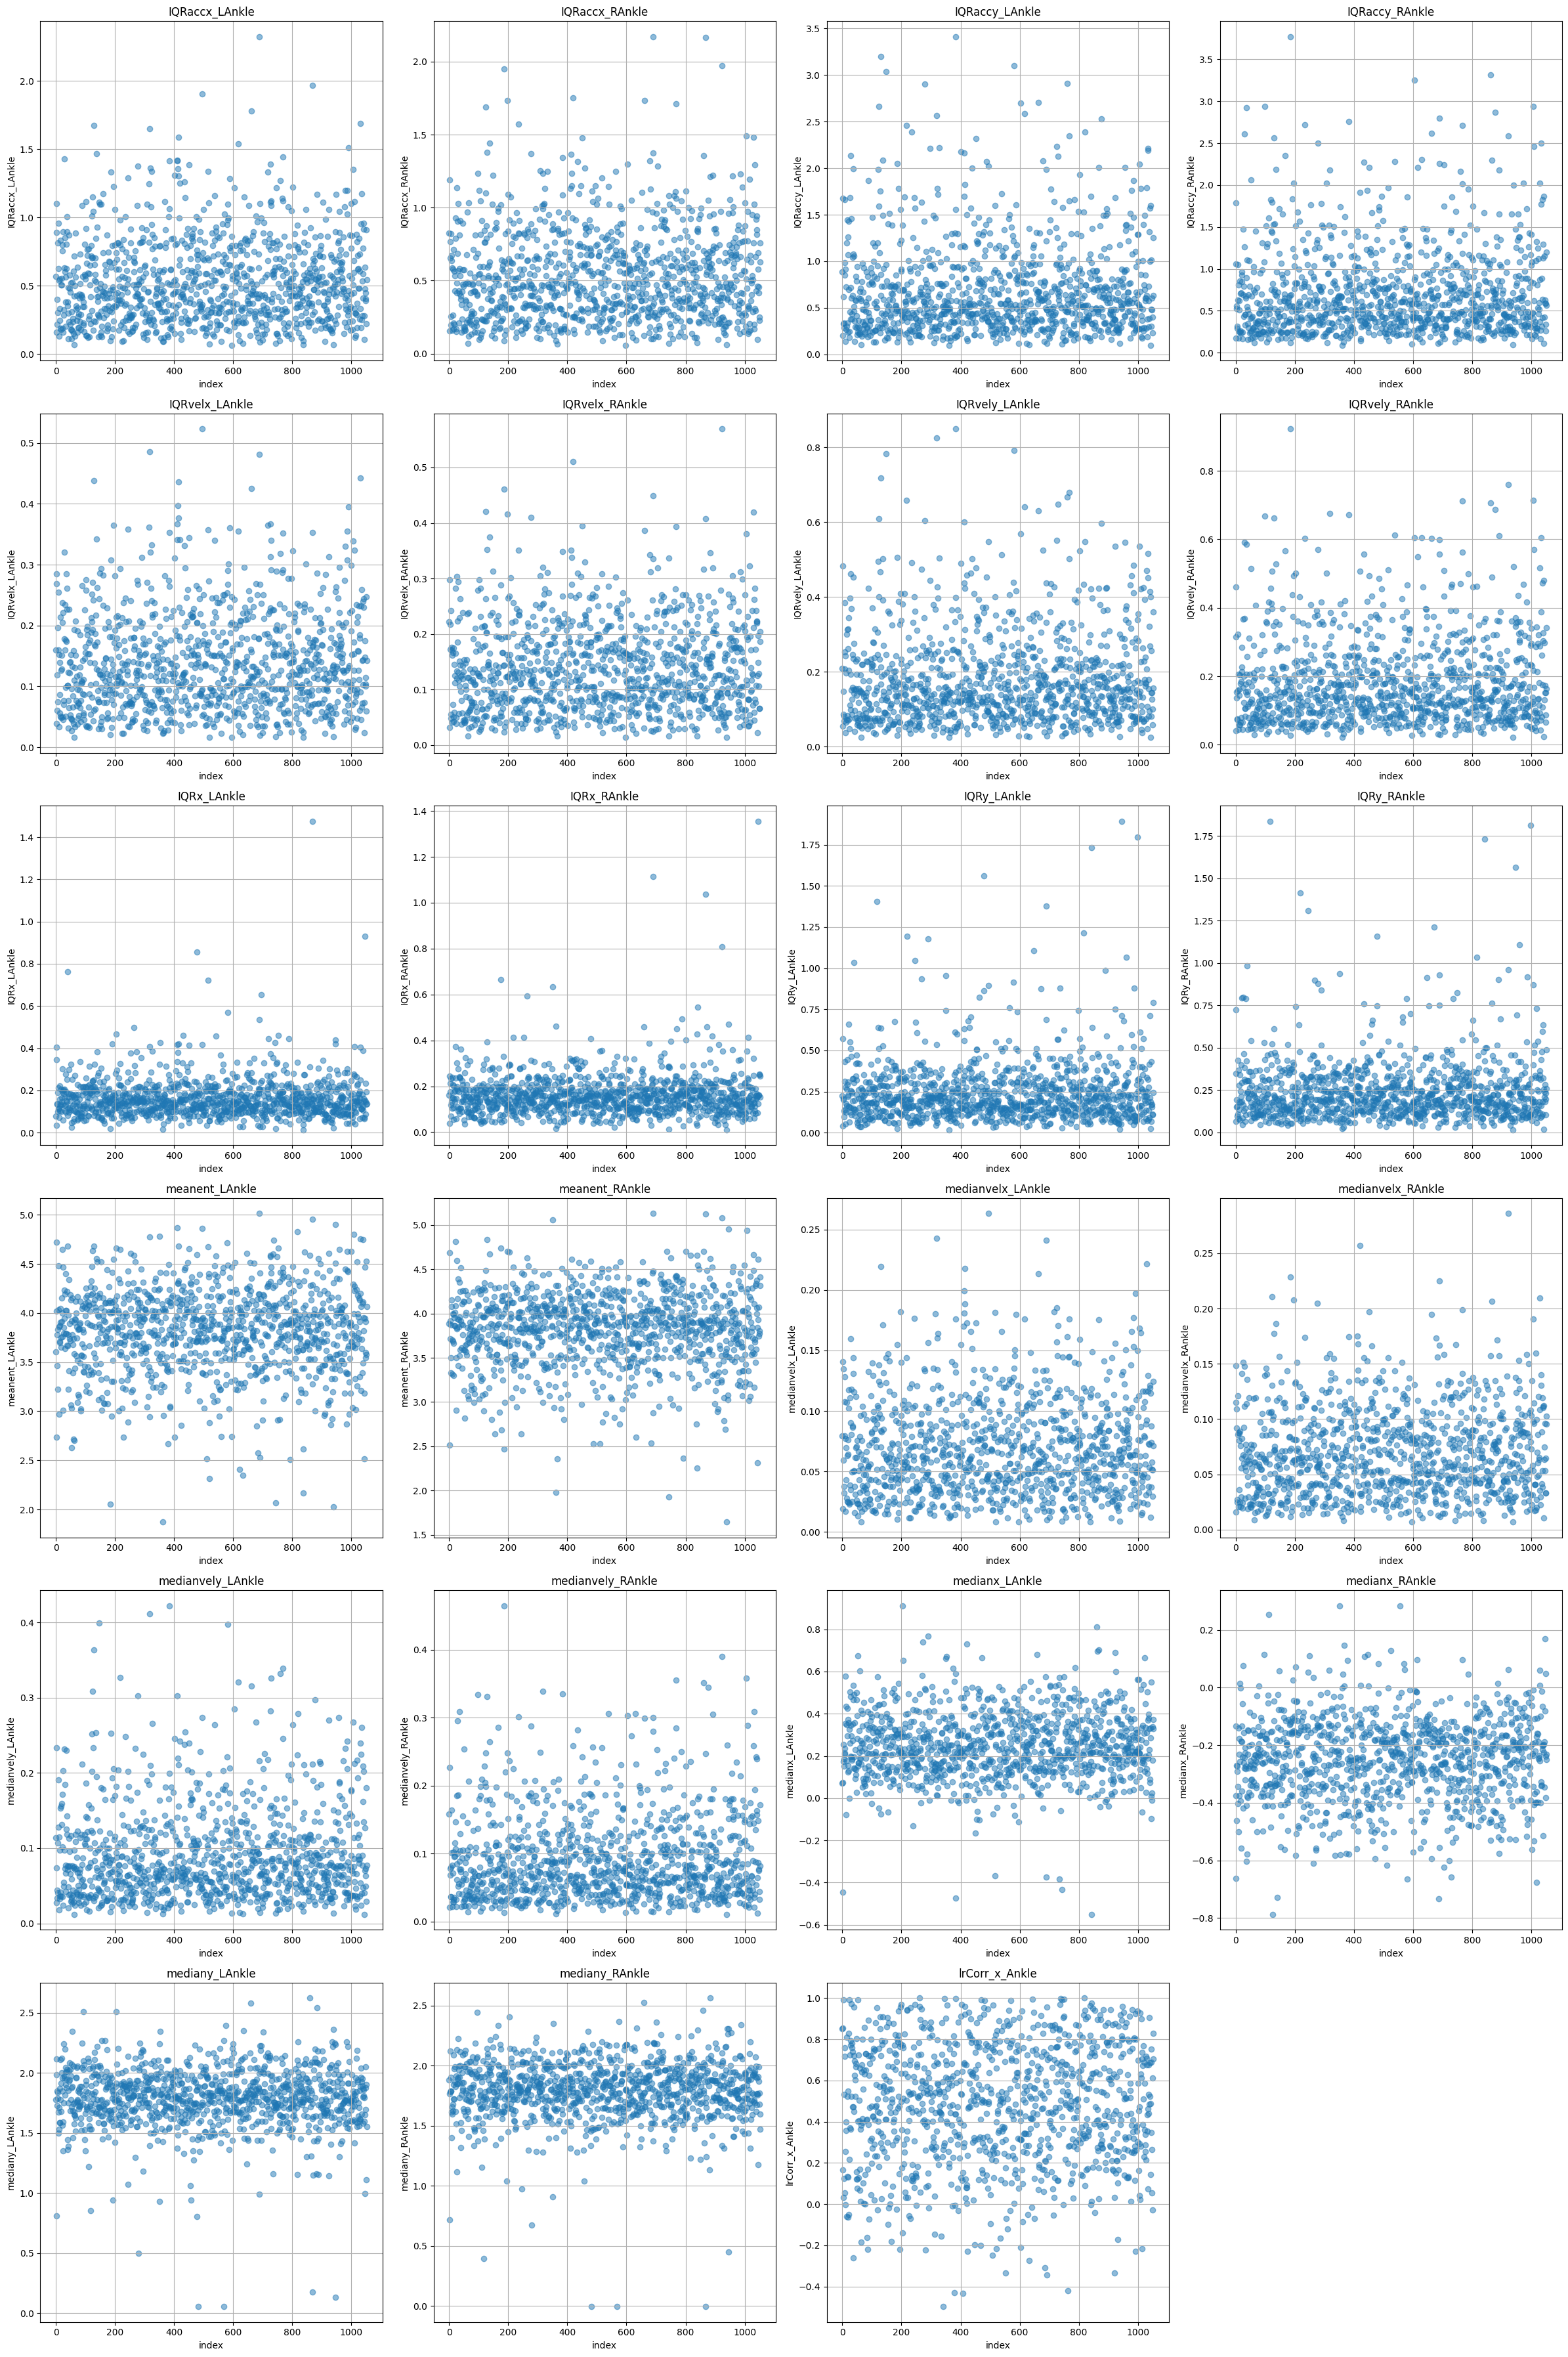

In [70]:
exclude_columns = ['video']
columns_to_plot = [col for col in features.columns if col not in exclude_columns]

bp = 'ankle'
columns = [col for col in columns_to_plot if bp in col.lower()]

# Create scatterplots
# Number of subplots
n_cols = 4  # Number of columns in the grid
n_rows = -(-len(columns) // n_cols)  # Ceiling division for the number of rows

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6 * n_rows), sharex=False, sharey=False)

# Flatten axes for easy iteration (if there's only one row, make sure it's iterable)
axes = axes.flatten()

# Plot each column in its subplot
for i, column in enumerate(columns):
    axes[i].scatter(features.index, features[column], alpha=0.5, label=column)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('index')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

# Remove empty subplots if there are any
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [73]:
os.makedirs(f'{pose_estimate_path}/window_features', exist_ok=True)

for csv in os.listdir(f'{pose_estimate_path}/xy_features/windows'):
    video_number = csv.split('_')[0]
    xy = pd.read_csv(f'{pose_estimate_path}/xy_features/windows/{csv}')   
    ang = pd.read_csv(f'{pose_estimate_path}/xy_features/windows/{csv}'.replace('xy','angle'))

    features = pd.merge(xy, ang, on=['video','frame'], how='inner').dropna()
    features.to_csv(f'{pose_estimate_path}/window_features/{csv}'.replace('xy','all'), header=True, index=False)

    del xy, ang, features

In [82]:
# Split features based on video file naming convention
if dataset == 'Youtube':
    features['infant'] = features['video'].str.split('_').str.get(1).str[-3:]
    features['session'] = features['video'].str.split('_').str.get(1).str[0]
    features['age'] = 'month'

elif dataset == 'Clinical':
    features['infant'] = features['video'].str.split('_').str.get(0).str[-1]
    features['session'] = features['video'].str.split('_').str.get(1).str[1]
    features['age'] = 'month'

elif dataset == 'gma_score_prediction' or dataset == 'PANDA2':
    features['infant'] = features['video']
    features['session'] = 0
    features['age'] = '3_4_Month'

if SAVE:
    features.to_csv(f'{pose_estimate_path}/features.csv', header=True, index=False)

In [83]:
# Body parts and sides for features avearaged across whole video 
features = pd.read_csv('pose_estimates/PANDA2_pose_estimates/features.csv')

body_parts = ["Knee", "Elbow", "Wrist", "Ankle","Hip","Shoulder"]
final_feature_bp = ['Knee','Elbow','Wrist','Ankle']

sides = ["L", "R"]

# Function to split the feature string into "feature", "part", and "side"
def split_feature(feature):
    # Split the feature into components
    parts = feature.split('_')
    feature_name = "_".join(parts[:-1])  # Default to everything before the last part
    part = parts[-1] if len(parts) > 1 else ""  # Default to the last part
    side = ""

    # Check if the last part has a side
    for body_part in body_parts:
        if body_part in part:  # Find body part
            idx = part.index(body_part)
            if idx > 0 and part[idx-1] in sides:  # Check for side prefix
                side = part[idx-1]
                part = part[idx:]  # Remove the side from the part            print(parts, idx)
            break  # Exit loop after finding the body part

    # # Adjust feature name to remove body part and side, if found
    if part in feature_name:
        feature_name = feature_name.replace(part, "").strip("_")
    if side + part in feature_name:  # Only remove the complete side+part combination
        feature_name = feature_name.replace(side + part, "").strip("_")
    # print(feature_name)
    return pd.Series([feature_name, part, side])


In [84]:

# Include data for the following, and restructure dataframe
# Customize for your specific dataset

id_vars = ['infant', 'age','session','video']
melted = pd.melt(features, id_vars=id_vars, var_name="feature", value_name="Value")

# Apply the function to the 'feature' column in your melted DataFrame
melted[['feature', 'part', 'side']] = melted['feature'].apply(split_feature)
melted = melted.dropna()

mean = melted.groupby(['infant', 'age', 'session', 'video', 'feature', 'part'])['Value'].mean().reset_index().drop(columns=['video'])
#Drop all rows with part not in body_parts (case insensitive)
# mean = mean[mean['part'].isin(final_feature_bp)]
mean.to_csv(f'{pose_estimate_path}/features_mean_by_side.csv', header=True, index=False)


mean.head()

,infant,age,session,feature,part,Value
0,0,3_4_Month,0,IQR_acc_angle,Elbow,40.184547
1,0,3_4_Month,0,IQR_acc_angle,Hip,17.666637
2,0,3_4_Month,0,IQR_acc_angle,Knee,26.246202
3,0,3_4_Month,0,IQR_acc_angle,Shoulder,24.132619
4,0,3_4_Month,0,IQR_vel_angle,Elbow,9.490872


In [85]:
# Body parts and sides for features averaged across windows

feature_files = os.listdir(f'{pose_estimate_path}/window_features')
os.makedirs(f'{pose_estimate_path}/features_window_mean_by_side', exist_ok=True)


features_windows_mean_by_side = pd.DataFrame()
id_vars = ['video','frame']

def process_feature_file(file):
    # Read each feature file
    features_current = pd.read_csv(f'{pose_estimate_path}/window_features/{file}')
    
    # Melt the current features dataframe
    melted = pd.melt(features_current, id_vars=id_vars, var_name="feature", value_name="Value")

    # Split feature column into components
    melted[['feature', 'part', 'side']] = melted['feature'].apply(split_feature)
    melted = melted.dropna()

    # Calculate means for current file
    mean = melted.groupby(['video', 'frame','feature', 'part'])['Value'].mean().reset_index()
    mean = mean[mean['part'].isin(final_feature_bp)]
    
    # write to csv
    mean.to_csv(f'{pose_estimate_path}/features_window_mean_by_side/{file}', header=True, index=False)


In [86]:
# check which files are missing
missing_files = [file for file in feature_files if not os.path.exists(f'{pose_estimate_path}/features_window_mean_by_side/{file}')]
print(len(missing_files))

1053


In [87]:

with Pool(processes=10) as pool:
    pool.map(process_feature_file, missing_files)


Process ForkPoolWorker-212:
Process ForkPoolWorker-214:


KeyboardInterrupt: 

In [ ]:

feature_part_combos = mean[['feature', 'part']].drop_duplicates()

# Create subplot grid
n_combos = len(feature_part_combos)
n_cols = 3
n_rows = (n_combos + n_cols - 1) // n_cols
plt.figure(figsize=(20, 5*n_rows))

# Plot distribution for each feature/part combination
for idx, (_, combo) in enumerate(feature_part_combos.iterrows()):
    feature = combo['feature']
    part = combo['part']
    
    plt.subplot(n_rows, n_cols, idx+1)
    

    # Plot histograms with colorblind friendly colors
    
    subset = mean[(mean['feature'] == feature) & (mean['part'] == part)]
    plt.hist(subset['Value'], bins=30, alpha=0.6, label='All Frames', color='#0077BB')  # Blue
    
    plt.title(f'{feature} - {part}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# for each feature plot the distribution of the values across all videos (where each video is a different file)

# get all files in the features_window_mean_by_side folder
feature_files = os.listdir(f'{pose_estimate_path}/features_window_mean_by_side')
file = pd.read_csv(f'{pose_estimate_path}/features_window_mean_by_side/{feature_files[0]}')

feature_part_combos = file[['feature', 'part']].drop_duplicates()

file.head()

In [12]:
# Get first feature/part combo
all_files = os.listdir(f'{pose_estimate_path}/features_window_mean_by_side')
output_dir = f'{pose_estimate_path}/window_mean_by_feature'
os.makedirs(output_dir, exist_ok=True)

for idx, combo in feature_part_combos.iterrows():
    subset = pd.DataFrame()
    feature_name = f'{combo["feature"]}_{combo["part"]}'

    feature = combo['feature']
    part = combo['part']

    # Get subset for first combo
    for file in all_files:
        file = pd.read_csv(f'{pose_estimate_path}/features_window_mean_by_side/{file}')
        subset = pd.concat([subset, file[(file['feature'] == feature) & (file['part'] == part)]])

    subset.to_csv(f'{output_dir}/{feature_name}.csv', header=True, index=False)




In [ ]:

# make one file per feature, with all the values for that feature across all videos
for file in feature_files:
    df = pd.read_csv(f'{pose_estimate_path}/features_window_mean_by_side/{file}')
    feature = df['feature'].unique()[0]

    df.to_csv(f'{pose_estimate_path}/features_window_mean_by_side/{feature}.csv', header=True, index=False)


In [2]:
# select the final features using the following dictionary

feature_to_file_mapping = {

    "IQR ankle pos x": "IQR_x_Ankle",
    "Med ankle vel x": "median_vel_x_Ankle",
    "IQR ankle vel x": "IQR_vel_x_Ankle",
    "Entropy ankle pos": "mean_ent_Ankle",
    "IQR ankle accel x": "IQR_acc_x_Ankle",
    "Med ankle vel y": "median_vel_y_Ankle",
    "IQR ankle vel y": "IQR_vel_y_Ankle",
    "Med knee angle vel": "median_vel_Knee",
    "IQR knee angle vel": "IQR_vel_Knee",
    "Stdev knee angle": "stdev_angle_Knee",
    "Med wrist pos y": "median_y_Wrist",
    "IQR ankle pos y": "IQR_y_Ankle",
    "Entropy knee angle": "entropy_angle_Knee",
    "IQR knee angle accel": "IQR_acc_Knee",
    "Mean elbow angle": "mean_angle_Elbow",
    "IQR ankle accel y": "IQR_acc_y_Ankle",
    "Med ankle pos x": "median_x_Ankle",
    "Med wrist pos x": "median_x_Wrist",
    "Med ankle pos y": "median_y_Ankle",
    "Cross-corr elbow angle": "lrCorr_angle_Elbow",
    "Cross-corr wrist pos": "lrCorr_x_Wrist",
    "Mean knee angle": "mean_angle_Knee",
    "Cross-corr ankle pos": "lrCorr_x_Ankle",
    "IQR wrist pos x": "IQR_x_Wrist",
    "Cross-corr knee angle": "lrCorr_angle_Knee",
    "IQR wrist pos y": "IQR_y_Wrist",
    "Entropy wrist pos": "mean_ent_Wrist",
    "Med wrist vel x": "median_vel_x_Wrist",
    "IQR wrist vel x": "IQR_vel_x_Wrist",
    "IQR wrist accel x": "IQR_acc_x_Wrist",
    "Med wrist vel y": "median_vel_y_Wrist",
    "IQR wrist vel y": "IQR_vel_y_Wrist",
    "IQR wrist accel y": "IQR_acc_y_Wrist",
    "Stdev elbow angle": "stdev_angle_Elbow",
    "IQR elbow angle accel": "IQR_acc_Elbow",
    "Entropy elbow angle": "entropy_angle_Elbow",
    "IQR elbow angle vel": "IQR_vel_Elbow",
    "Med elbow angle vel": "median_vel_Elbow",
}


In [ ]:

os.makedirs(f'{pose_estimate_path}/window_mean_by_feature/final', exist_ok=True)

for file, feature in feature_to_file_mapping.items():
    #print(f'now renaming {feature} to {file}')
    new_feature_name = file.replace(' ', '_')
    # print(f'renaming {feature} to {new_feature_name}')
    shutil.copy(f'{pose_estimate_path}/window_mean_by_feature/{feature}.csv', f'{pose_estimate_path}/window_mean_by_feature/final/{new_feature_name}.csv')


In [5]:
feature_mapping = {
    "IQR_x_Ankle": "IQR_ankle_pos_x",
    "IQRx_Ankle": "IQR_ankle_pos_x",
    "median_vel_x_Ankle": "Med_ankle_vel_x",
    "medianvelx_Ankle": "Med_ankle_vel_x",
    "IQR_vel_x_Ankle": "IQR_ankle_vel_x",
    "IQRvelx_Ankle": "IQR_ankle_vel_x",
    "mean_ent_Ankle": "Entropy_ankle_pos",
    "meanent_Ankle": "Entropy_ankle_pos",
    "IQR_acc_x_Ankle": "IQR_ankle_accel_x",
    "IQRaccx_Ankle": "IQR_ankle_accel_x",
    "median_vel_y_Ankle": "Med_ankle_vel_y",
    "medianvely_Ankle": "Med_ankle_vel_y",
    "IQR_vel_y_Ankle": "IQR_ankle_vel_y",
    "IQRvely_Ankle": "IQR_ankle_vel_y",
    "median_vel_Knee": "Med_knee_angle_vel",
    "median_vel_angle_Knee": "Med_knee_angle_vel",
    "IQR_vel_Knee": "IQR_knee_angle_vel",
    "IQR_vel_angle_Knee": "IQR_knee_angle_vel",
    "median_y_Wrist": "Med_wrist_pos_y",
    "mediany_Wrist": "Med_wrist_pos_y",
    "IQR_y_Ankle": "IQR_ankle_pos_y",
    "IQRy_Ankle": "IQR_ankle_pos_y",
    "entropy_angle_Knee": "Entropy_knee_angle",
    "IQR_acc_Knee": "IQR_knee_angle_accel",
    "IQR_acc_angle_Knee": "IQR_knee_angle_accel",
    "mean_angle_Elbow": "Mean_elbow_angle",
    "IQR_acc_y_Ankle": "IQR_ankle_accel_y",
    "IQRaccy_Ankle": "IQR_ankle_accel_y",
    "median_x_Ankle": "Med_ankle_pos_x",
    "medianx_Ankle": "Med_ankle_pos_x",
    "median_x_Wrist": "Med_wrist_pos_x",
    "medianx_Wrist": "Med_wrist_pos_x",
    "median_y_Ankle": "Med_ankle_pos_y",
    "mediany_Ankle": "Med_ankle_pos_y",
    "lrCorr_angle_Elbow": "Cross-corr_elbow_angle",
    "lrCorr_angle_Knee": "Cross-corr_knee_angle",
    "lrCorr_x_Wrist": "Cross-corr_wrist_pos",
    "mean_angle_Knee": "Mean_knee_angle",
    "lrCorr_x_Ankle": "Cross-corr_ankle_pos",
    "IQR_x_Wrist": "IQR_wrist_pos_x",
    "IQRx_Wrist": "IQR_wrist_pos_x",
    "IQR_y_Wrist": "IQR_wrist_pos_y",
    "IQRy_Wrist": "IQR_wrist_pos_y",
    "mean_ent_Wrist": "Entropy_wrist_pos",
    "meanent_Wrist": "Entropy_wrist_pos",
    "median_vel_x_Wrist": "Med_wrist_vel_x",
    "medianvelx_Wrist": "Med_wrist_vel_x",
    "IQR_vel_x_Wrist": "IQR_wrist_vel_x",
    "IQRvelx_Wrist": "IQR_wrist_vel_x",
    "IQR_acc_x_Wrist": "IQR_wrist_accel_x",
    "IQRaccx_Wrist": "IQR_wrist_accel_x",
    "median_vel_y_Wrist": "Med_wrist_vel_y",
    "medianvely_Wrist": "Med_wrist_vel_y",
    "IQR_vel_y_Wrist": "IQR_wrist_vel_y",
    "IQRvely_Wrist": "IQR_wrist_vel_y",
    "IQR_acc_y_Wrist": "IQR_wrist_accel_y",
    "IQRaccy_Wrist": "IQR_wrist_accel_y",
    "stdev_angle_Elbow": "Stdev_elbow_angle",
    "stdev_angle_Knee": "Stdev_knee_angle",
    "IQR_acc_Elbow": "IQR_elbow_angle_accel",
    "IQR_acc_angle_Elbow": "IQR_elbow_angle_accel",
    "entropy_angle_Elbow": "Entropy_elbow_angle",
    "IQR_vel_Elbow": "IQR_elbow_angle_vel",
    "IQR_vel_angle_Elbow": "IQR_elbow_angle_vel",
    "median_vel_Elbow": "Med_elbow_angle_vel",
    "median_vel_angle_Elbow": "Med_elbow_angle_vel"
}

In [ ]:

os.makedirs(f'{pose_estimate_path}/window_mean_by_feature/final', exist_ok=True)

for file, feature in feature_to_file_mapping.items():
    #print(f'now renaming {feature} to {file}')
    new_feature_name = file.replace(' ', '_')
    # print(f'renaming {feature} to {new_feature_name}')
    shutil.copy(f'{pose_estimate_path}/window_mean_by_feature/{feature}.csv', f'{pose_estimate_path}/window_mean_by_feature/final/{new_feature_name}.csv')


In [ ]:
total_feature_file = 'pose_estimates/gma_score_prediction_pose_estimates/features_mean_by_side.csv'
total_features = pd.read_csv(total_feature_file)

total_features['feature_part'] = total_features['feature'].astype(str) + '_' + total_features['part'].astype(str)
unique_combinations = total_features['feature_part'].unique()

unique_combinations

In [ ]:
total_feature_file = 'pose_estimates/gma_score_prediction_pose_estimates/features_mean_by_side.csv'
total_features = pd.read_csv(total_feature_file)

total_features.head()

In [ ]:
for feature in total_features['feature_part'].unique():
    try: 
        print(f'{feature} --> {feature_mapping[feature]}')
    except KeyError: 
        continue


In [ ]:
final_features_total = pd.DataFrame()

for feature in total_features['feature_part'].unique():

    try: 
        new_feature_name = feature_mapping[feature]
    except KeyError: 
        continue

    slice = total_features[total_features['feature_part'] == feature]
    slice['new_feature'] = new_feature_name

    # Properly dropping columns and renaming with assignment
    slice = slice.drop(columns=['feature', 'feature_part','age','session'])  # Assuming 'feauture' is a typo and should be 'feature'
    slice = slice.rename(columns={'new_feature': 'feature'})
    
    if not slice.empty:
     final_features_total = pd.concat([final_features_total, slice])

display(final_features_total)

print(f'total number of features: {len(final_features_total.feature.unique())}')


In [22]:
final_features_total.to_csv(f'{pose_estimate_path}/all_features_total.csv')

In [ ]:
# concatenate all the files in the window_mean_by_feature/final folder into one file
final_features = pd.DataFrame()
for file in os.listdir(f'{pose_estimate_path}/window_mean_by_feature/final'):
    df = pd.read_csv(f'{pose_estimate_path}/window_mean_by_feature/final/{file}')
    df['feature'] = file.replace('.csv', '')
    df.rename(columns={'video': 'infant'}, inplace=True)
    #write iteratively to a csv file
    # if the file doesn't exist, write the header
    if not os.path.exists(f'{pose_estimate_path}/window_mean_by_feature/final/all_features.csv'):
        df.to_csv(f'{pose_estimate_path}/window_mean_by_feature/final/all_features.csv', header=True, index=False)
    else:
        df.to_csv(f'{pose_estimate_path}/window_mean_by_feature/final/all_features.csv', mode='a', header=False, index=False)



In [ ]:

window_features = pd.read_csv(f'{pose_estimate_path}/window_mean_by_feature/final/all_features.csv')
windows_mean = window_features.groupby(['infant','feature','part']).mean().drop(columns='frame').reset_index()
display(windows_mean)


In [17]:
windows_features_final = windows_mean.pivot_table(index=['infant'], columns='feature', values='Value', aggfunc='mean').reset_index() 
windows_features_final = windows_features_final.reset_index().rename_axis(None, axis=1)
windows_features_final = windows_features_final.drop(columns='index')
windows_features_final.head()

windows_features_final.to_csv(f'{pose_estimate_path}/window_mean_by_feature/final/final_window_features.csv')

In [ ]:
final_features_total = pd.read_csv(f'{pose_estimate_path}/all_features_total.csv')
final_features_total = final_features_total.pivot_table(index=['infant'], columns='feature', values='Value', aggfunc='mean').reset_index()
final_features_total  = final_features_total .reset_index().rename_axis(None, axis=1)
final_features_total  = final_features_total .drop(columns='index')

final_features_total.to_csv(f'{pose_estimate_path}/final_total_features.csv')
final_features_total.head()

In [ ]:
for feature in windows_mean.feature.unique():
    if feature not in final_features_total.feature.unique():
        print(feature)

In [ ]:
for feature in final_features_total.feature.unique():
    if feature not in windows_mean.feature.unique():
        print(feature)

In [ ]:
len(final_features_total)

In [ ]:
len(windows_features_final)

In [ ]:
# make subplots for each column in the final features dataframes comparing windowed and total features

# Get the list of features

features = final_features_total.columns[1:]  # Exclude 'infant' column

# Create a figure and subplots
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(features) // n_cols)  # Ceiling division for the number of rows
plt.figure(figsize=(20, 5*n_rows))

# Plot each feature in its subplot with a correlation coefficient

for i, feature in enumerate(features):
    # comput the correlation between total and windows 
    r = final_features_total[feature].corr(windows_features_final[feature])

    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(final_features_total[feature], windows_features_final[feature], alpha=0.5)
    plt.title(f'{feature}: R2 = {r:.2f}')
    plt.xlabel('Total Feature')
    plt.ylabel('Window Feature')
    plt.grid(True)